# Model Setup

In [3]:
# install python packages required to solve model
!pip install pulp
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install geopandas
!pip install ast
!pip install mapclassify

from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from ast import keyword


# DATASETS
# census tract information
ct = pd.read_csv('../data/2023Stocking_2010CT_HVI.csv', index_col = 0)

# zone information
zones = pd.read_csv('../data/Zones_Year_Assignment.csv', index_col = 0)
zones.columns = zones.columns.str.strip()
zones.set_index("Unique", inplace = True)
zones["merge_id"] = zones["Community Board"].astype(str) + "_" + zones["Council District"].astype(str) + "_" + zones["Planting Potential"].astype(str)

# zone to ct joined table
zone_ct_pgi = pd.read_csv('../data/CT_NTP_Zone_Key.csv')
zones_resetindex = zones.reset_index()
zones_resetindex["Zone_Unique"] = zones_resetindex["Unique"]
zone_ct_pgi["Zone_Unique"] = zone_ct_pgi["CommunityBoardWater"].astype(str) + "_" + zone_ct_pgi["Zone ID"].astype(str)

# SHAPEFILES

# census tract map
ct_shp = gpd.read_file("../data/Stocking_CT_HVI_2015_shp/Stocking_CT_HVI_2015.shp")

# zone map
zone_shp = gpd.read_file("../data/Zone_shp/Zone_map.shp")

# transition map
transition_shp = gpd.read_file("../data/transition_phases/transition_phases.shp")
transition_shp = transition_shp[transition_shp["Year_Per_R"] >= 2025]


# JOINS

# zones + zone to ct joined table
zones_merged = zones_resetindex.merge(
    zone_ct_pgi,
    on="Zone_Unique",
    how="left",
    suffixes=('', '_zone_ct_pgi')
)

# ct + zone to ct joined table
ct_merged = ct.merge(
    zone_ct_pgi,
    left_on='BoroCT2010',
    right_on='BoroCT2010',
    how='left',
    suffixes=('', '_zone_ct_pgi')
)

zone_shp = zone_shp.to_crs(transition_shp.crs)

# merge key between zones and ct
zone_shp["merge_id"] = zone_shp["CommunityB"].astype(str) + "_" + zone_shp["CouncilDis"].astype(str) + "_" + zone_shp["SUM_Planti"].astype(str)

# mapping to find zones in transition phase using geometries
zone_transition_map = gpd.sjoin(zone_shp[["merge_id", "geometry"]],
                   transition_shp[["OBJECTID", "geometry", "Year_Per_R"]],
                   how="inner", predicate="within")
mapping_transition_zones = zone_transition_map.groupby("OBJECTID", as_index=False).agg({"merge_id": list, "Year_Per_R": list})
mapping_transition_zones


# MORE DEFINTIONS / SETS

# set of all zones
I = zones.index.tolist()

# set of years in the 9-year cycle
Y = [i for i in range(9)]

# Zone ID -> Community Board
community_boards = zones["Community Board"].to_dict()

# Zone ID -> HVI
hvi_scores = zones["HVI"].to_dict()

# Zone ID -> Tree planting potential
planning_potentials = zones["Planting Potential"].to_dict()

# Linear scaling function of HVI scores
min_hvi = zones["HVI"].min()
max_hvi = zones["HVI"].max()

def hvi_weight(hvi):
  return 1 + 4 * (hvi - min_hvi) / (max_hvi - min_hvi)

# time penalty encouraging high-HVI zones to be assigned earlier in the cycle
def time_weight(j):
  n_years = len(Y)
  return np.exp(-0.1 * (j - 1))


# COMPUTE TRACT AREAS
# Ensure correct projected CRS for area calculation
if not ct_shp.crs.is_projected:
    ct_shp = ct_shp.to_crs(epsg=6539)  # Example: NAD83 / New York Long Island (use your project CRS)

# Calculate area in square meters (or your CRS units)
ct_shp['Tract_Area'] = ct_shp.geometry.area
# Calculate priority scores for each CT based on its HVI quintile and area
ct_shp['HVI_Area_Weighted'] = ct_shp['QUINTILES'] * ct_shp['Tract_Area']
# Ensure consistent keys
ct_shp['BoroCT2010'] = ct_shp['BoroCT2010'].astype(str)
zone_ct_pgi['BoroCT2010'] = zone_ct_pgi['BoroCT2010'].astype(str)

# Merge tract HVI scores into zone_ct_pgi
zone_ct_pgi = zone_ct_pgi.merge(
    ct_shp[['BoroCT2010', 'HVI_Area_Weighted']],
    on='BoroCT2010',
    how='left'
)

# For each zone, find the sum of priority scores of CTs in the zone
zone_priority_scores = zone_ct_pgi.groupby('Zone ID')['HVI_Area_Weighted'].sum().reset_index()
zone_priority_scores.rename(columns={'HVI_Area_Weighted': 'Zone_Priority_Score'}, inplace=True)
zones_merged = zones_merged.merge(zone_priority_scores, on='Zone ID', how='left')
zones_merged = zones_merged.sort_values(by='Zone_Priority_Score', ascending=False)
zones_merged['Priority_Score_Normalized'] = (
    zones_merged['Zone_Priority_Score'] - zones_merged['Zone_Priority_Score'].min()
) / (zones_merged['Zone_Priority_Score'].max() - zones_merged['Zone_Priority_Score'].min())


# CONSTRAINT CHECKER
from pulp import LpConstraint, LpConstraintEQ, LpConstraintLE, LpConstraintGE

def constraint_checker(model, threshold=1e-5):
    print("\n Constraint Status Report")
    violated_constraints = []
    binding_constraints = []

    for cname, constr in model.constraints.items():
        lhs_value = sum(var.varValue * coeff for var, coeff in constr.items())
        rhs_value = constr.constant

        if constr.sense == LpConstraintEQ:  # Equality
            slack = abs(lhs_value - rhs_value)
            satisfied = slack <= threshold
        elif constr.sense == LpConstraintLE:  # Less than or equal
            slack = rhs_value - lhs_value  # Should be ≥ 0
            satisfied = slack >= -threshold
        elif constr.sense == LpConstraintGE:  # Greater than or equal
            slack = lhs_value - rhs_value  # Should be ≥ 0
            satisfied = slack >= -threshold
        else:
            continue  # Skip if unknown

        if not satisfied:
            violated_constraints.append((cname, slack, lhs_value, rhs_value, constr.sense))
        elif abs(slack) <= threshold:
            binding_constraints.append((cname, slack, lhs_value, rhs_value, constr.sense))

    if violated_constraints:
        print(f"\n Violated Constraints: {len(violated_constraints)}")
        for cname, slack, lhs, rhs, sense in violated_constraints[:10]:  # show top 10
            print(f"Constraint: {cname}")
            print(f"  LHS: {lhs}, RHS: {rhs}, Slack: {slack}")
            print(f"  Sense: {sense}")
            print("-" * 40)
    else:
        print("\n No violated constraints found.")

    if binding_constraints:
        print(f"\n Binding Constraints: {len(binding_constraints)} (Slack ~ 0)")
        for cname, slack, lhs, rhs, sense in binding_constraints[:10]:
            print(f"Constraint: {cname}")
            print(f"  LHS: {lhs}, RHS: {rhs}, Slack: {slack}")
            print(f"  Sense: {sense}")
            print("-" * 40)
    else:
        print("\nNo binding constraints detected.")

    print("\n End of Report")

  Using cached AST-0.0.2.tar.gz (19 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/75/vd_hn7vj3996l4xb0lb6kgkh0000gn/T/pip-install-l8maq7nc/ast_6270393f289e47cbbb933c07839bbb12/setup.py", line 6, in <module>
          README = codecs.open(os.path.join(here, 'AST/README'), encoding='utf8').read()
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "<frozen codecs>", line 905, in open
      FileNotFoundError: [Errno 2] No such file or directory: '/private/var/folders/75/vd_hn7vj3996l4xb0lb6kgkh0000gn/T/pip-install-l8maq7nc/ast_6270393f289e47cbbb933c07839bbb12/AST/README'
      [end of output]
  
  note: This error originates from a

# **Model**

In [ ]:
model = LpProblem("Tree_Planting_Scheduling", LpMaximize)

# 1. DECISION VARIABLES
  # x[i,j] = 1 if zone i is assigned to year j
x = {(i, j): LpVariable(f"x_{i}_{j}", cat="Binary") for i in I for j in Y}

  # p[i,j] is the # of trees planted in zone i in year j
p = {
    (i, j): LpVariable(f"p_{i}_{j}", lowBound=0, upBound=planning_potentials[i])
    for i in I for j in Y
}


# 2. CONSTRAINTS

# A. Each zone must be scheduled exactly once across 9 years
for i in I:
    model += lpSum(x[i, j] for j in Y) == 1

# B. Handle CBs that exceed the 1300 limit
# PLEASE ADJUST overflow_cbs TO DATA
overflow_cbs = [412, 413, 414, 502, 503]

# Binary overflow flags
overflow_cb_var = {(cb, j): LpVariable(f"overflow_{cb}_{j}", cat="Binary")
               for cb in overflow_cbs for j in Y}

# Allow 1300 + delta if overflow_cb is used

# PLEASE ADJUST delta
delta = 1000
for cb in [412, 413, 414, 502, 503]:
    cb_tracts = [i for i in I if community_boards[i] == cb]
    for j in Y:
        model += (
            lpSum(p[i,j] for i in cb_tracts) <= 1299 + delta * overflow_cb_var[(cb, j)]
        )

# C. At most 1 CB overflow per year
for j in Y:
    model += lpSum(overflow_cb_var[(cb, j)] for cb in [412, 413, 414, 502, 503]) <= 1

# D. CB-Year tree capacity constraint (<1300 trees per CB per year) for all other CBs
unique_cbs = set(community_boards.values())
for cb in unique_cbs:
    if cb not in overflow_cbs:
      cb_tracts = [i for i in I if community_boards[i] == cb]
      for j in Y:
          model += (
              lpSum(p[i,j] for i in cb_tracts) <= 1299,
              f"Capacity_CB{cb}_Year{j}"
          )

# E. Trees can only be planted in a given zone in a given year if it is assigned to that year
for i in I:
  for j in Y:
    model += p[i,j] <= planning_potentials[i] * x[i,j]

# F. Visit at least one zone in one CB in every 3 years in the cycle
cb_set = set(community_boards.values())
for cb in cb_set:
    cb_tracts = [i for i in I if community_boards[i] == cb]
    if len(cb_tracts) > 2:
      for start in [0,3,6]:
        three_y_block = range(start, start+3)
        model += lpSum(x[i,j] for i in cb_tracts for j in three_y_block) >= 1
    else:
      model += lpSum(x[i,j] for i in cb_tracts for j in Y) == len(cb_tracts)


# G. Balance constraint in # of Trees Planted
trees_per_year = {
    j: lpSum(p[i, j] for i in I)
    for j in Y
}

for j in Y:
  # cannot plant more than 20000 trees per year
  model += trees_per_year[j] <= 20000
  # best not to plant below 5000 trees per year, can change
  model += trees_per_year[j] >= 5000

# Pairwise deviation variables - dictionary mapping from pair of years (1-9)
# to their difference in # of trees planted (p[i,j])
pairwise_deviation_vars = {}

for j1 in Y:
    for j2 in Y:
        if j1 < j2:
            var_name = f"dev_{j1}_{j2}"
            pairwise_deviation_vars[(j1, j2)] = LpVariable(var_name, lowBound=0)

            # Absolute deviation constraints
            model += trees_per_year[j1] - trees_per_year[j2] <= pairwise_deviation_vars[(j1, j2)]
            model += trees_per_year[j2] - trees_per_year[j1] <= pairwise_deviation_vars[(j1, j2)]

# Cap on total deviation across all pairs
model += lpSum(pairwise_deviation_vars.values()) <= 10000, "TotalPairwiseDeviationCap"


# H. Limit each zone to be scheduled in the same or earlier phase than manual assignment
restricted_zones = ['108_1', '203_4', '209_6', '316_1']

for i in I:
    assigned_year = zones.loc[i, "New Year Assignment"]
    if pd.notnull(assigned_year):
        assigned_year_idx = int(assigned_year) - 1  # convert to 0-based index
        if i in restricted_zones:
          assigned_year_idx += 2
        for j in Y:
            if j > assigned_year_idx:
                model += x[i, j] == 0

# I. All transition plan zones (visited 2025-2026) cannot be visited within the next 5 years of the following cycle
model_version = 2
penalty_weight = 1000

slack_vars = {}
for index, t_zone in mapping_transition_zones.iterrows():
    zones_t = t_zone["merge_id"]  # list of merge_ids (strings)
    year_planted_list = t_zone["Year_Per_R"]  # list of years matching zones_t

    for zone_merge_id, year_planted in zip(zones_t, year_planted_list):
        if year_planted == 2025:
            if model_version == 3:
                restricted_years = Y[:6]
            else:
                restricted_years = Y[:2]
        elif year_planted == 2026:
            if model_version == 3:
                restricted_years = Y[:7]
            else:
                restricted_years = Y[:3]
        else:
            continue

        # find matching index in zones DataFrame
        matching_indices = zones.index[zones["merge_id"] == zone_merge_id].tolist()
        if not matching_indices:
            print(f"Warning: {zone_merge_id} not found in zones DataFrame")
            continue

        for i in matching_indices:
            for y in restricted_years:
                # slack_vars[(i,y)] = LpVariable(f"slack_{i}_{y}", lowBound=0, upBound=1, cat="Continuous")
                # Relax the hard constraint to x[i,y] ≤ slack[i,y]
                  model += x[i,y] == 0


# 3. OBJECTIVE FUNCTION
objective = lpSum([
    zones_merged['Priority_Score_Normalized'] * time_weight(j) * p[i, j]
    for i in I for j in Y
])
# New objective value should be at least as high as that of manual objective value
manual_obj = 313914.07
model += objective >= manual_obj, "MinObjectiveThreshold"
model += objective


# 4. CONSTRAINT CHECKER
# Collect all (i,j) pairs where x[i,j] == 0 constraints exist
restricted_vars = set()
zone_constraint_map = {}

for cname, constr in model.constraints.items():
    if len(constr.items()) == 1 and constr.constant == 0:
        var, coeff = list(constr.items())[0]
        if coeff == 1 and var.name.startswith("x_"):
            parts = var.name.split('_')
            i_var = "_".join(parts[1:-1])
            j_var = int(parts[-1])
            restricted_vars.add((i_var, j_var))

            # Track which constraint is restricting this assignment
            zone_constraint_map.setdefault((i_var, j_var), []).append(cname)

# Check for each zone if all years are restricted
for i in I:
    restricted_years = [j for j in Y if (i, j) in restricted_vars]
    if len(restricted_years) == len(Y):
        print(f" Zone {i} is restricted in all years! No feasible assignment possible.")
        print(f"   Years restricted: {restricted_years}")
        print(f"   Constraints causing restriction:")
        for j in restricted_years:
            for cname in zone_constraint_map[(i, j)]:
                print(f"      - {cname}: {model.constraints[cname]}")

# 5. SOLVE
from pulp import PULP_CBC_CMD
model.solve(PULP_CBC_CMD(msg=True, timeLimit=600))
if LpStatus[model.status] != "Optimal":
    print("WARNING: No feasible solution found. Status =", LpStatus[model.status])
    constraint_checker(model)
else:
    print("Optimal solution found! Objective =", value(model.objective))

zones_per_year = np.zeros(9)
for var in model.variables():
    if var.varValue is not None and var.varValue > 1e-10:
        name = var.name
        parts = name.split('_')
        var_type = parts[0]
        year = parts[-1]
        shifted_year = str(int(year) + 1)
        zone_id = "_".join(parts[1:-1])
        if var_type == "p":
          print(f"Zone: {zone_id} is assigned to Year: {shifted_year}, {round(var.varValue)} trees to plant")
        else:
          zones_per_year[int(year)] += 1


model_assignment = {}
for var in model.variables():
    if var.name.startswith("x_") and var.varValue == 1:
        parts = var.name.split('_')
        i = "_".join(parts[1:-1])
        year = int(parts[-1]) + 1
        model_assignment[i] = year

def get_phase(year):
    if year <= 3: return 1
    elif year <= 6: return 2
    else: return 3

zones["Reassigned_Year"] = zones.index.map(model_assignment)
zones["Reassigned_Phase"] = zones["Reassigned_Year"].apply(get_phase)
zones["Manual_Phase"] = zones["New Year Assignment"].apply(get_phase)
zones["Phase_Change"] = zones["Manual_Phase"] - zones["Reassigned_Phase"]
zones["Assigned_Year"] = zones.index.map(model_assignment)

merged_gdf = zone_shp.merge(zones[["merge_id", "Assigned_Year", "Reassigned_Year", "Reassigned_Phase", "Manual_Phase","New Year Assignment"]], on="merge_id", how = "left")


# 6. SAVE MODEL SCHEDULE
assignments_x = []
assignments_p = []

for i in I:
    for j in Y:
        var_x = x[i, j]
        var_p = p[i, j]

        if var_x.varValue is not None and var_x.varValue > 0.5:
            assignments_x.append((i, j+1, var_x.varValue))

        if var_p.varValue is not None and var_p.varValue > 0.5:
            # (zone, year, trees)
            assignments_p.append((i, j+1, var_p.varValue))

start_year = 2027
end_year = 2035
assign_col = f"{start_year}-{end_year}_Model_Assignment"
trees_col = f"{start_year}-{end_year}_trees_to_plant"

df_assign = pd.DataFrame(assignments_p, columns=['Zone', assign_col, trees_col])
df_updated = zones.merge(df_assign.set_index('Zone'),
                         left_index=True, right_index=True, how='left')
df_updated = df_updated.drop(["merge_id", "Reassigned_Year", "Reassigned_Phase", "Manual_Phase", "Phase_Change", "Assigned_Year"], axis=1)
df_updated.to_csv(f"Zones_Year_Assignment_{start_year}_{end_year}.csv")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Applications/anaconda3/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/75/vd_hn7vj3996l4xb0lb6kgkh0000gn/T/901cd20bd8cd46f389308d9f23f58288-pulp.mps -max -sec 600 -timeMode elapsed -branch -printingOptions all -solution /var/folders/75/vd_hn7vj3996l4xb0lb6kgkh0000gn/T/901cd20bd8cd46f389308d9f23f58288-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6815 COLUMNS
At line 110967 RHS
At line 117778 BOUNDS
At line 125384 ENDATA
Problem MODEL has 6810 rows, 7641 columns and 92721 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 600
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.82181e+08 - 0.07 seconds
Cgl0002I 1803 variables fixed
Cgl0008I 9 inequality constraints converted to equality constraints
Cgl0003I 107 fixed, 0 tightened bounds, 39 strengthened rows, 12 substitution

In [6]:
# 8. PRINT SOLUTION
df_display = df_assign.sort_values(by=[assign_col, 'Zone'])
print(df_display.to_string(index=False))

  Zone  2027-2035_Model_Assignment  2027-2035_trees_to_plant
 105_1                           1                    140.00
 105_2                           1                    156.00
 105_3                           1                    166.00
 105_4                           1                    165.00
 105_6                           1                    152.00
 106_1                           1                    127.00
 106_2                           1                    131.00
 107_1                           1                    140.00
 205_1                           1                    147.00
 208_4                           1                    191.00
 208_7                           1                    166.00
 208_9                           1                    128.00
 211_1                           1                    165.00
211_13                           1                    136.00
211_15                           1                    123.00
 211_2                  

# **Analytics**

# Phase Changes on a Map

Phase_Change
-2.0      1
-1.0      7
 0.0    431
 1.0      3
Name: count, dtype: int64


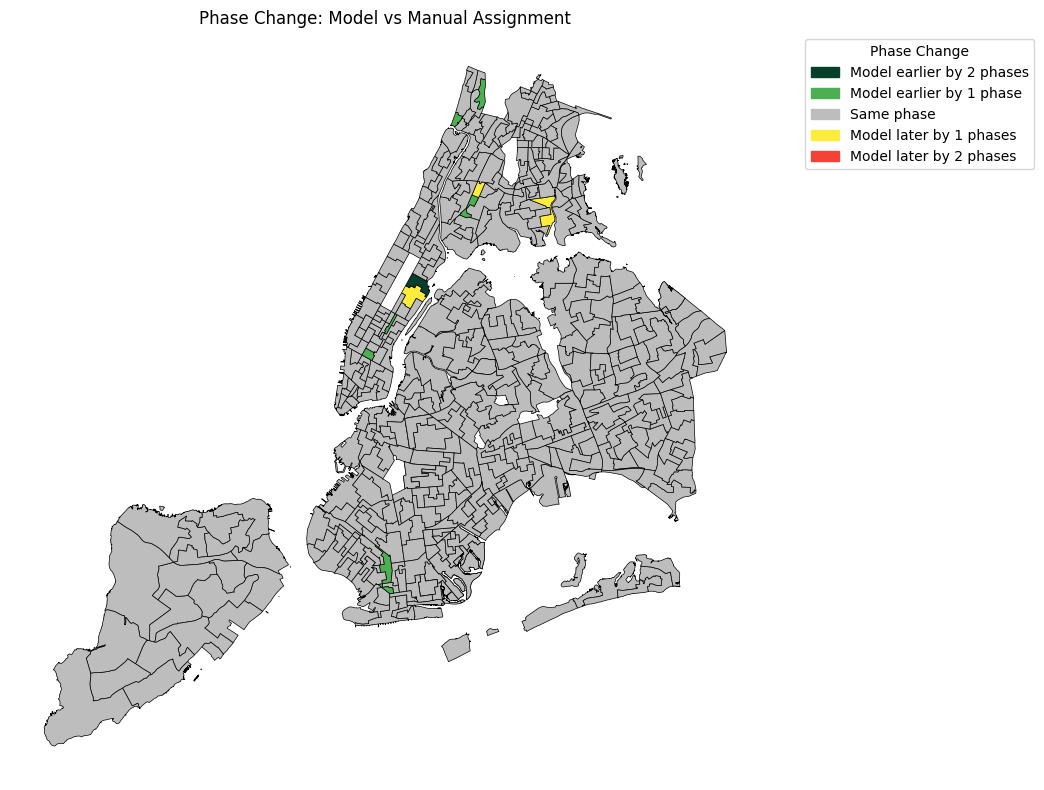

In [7]:
import matplotlib.patches as mpatches

# Add explicit handling for missing phases
merged_gdf["Phase_Change"] = np.where(
    merged_gdf["Reassigned_Year"].isna() | merged_gdf["New Year Assignment"].isna(),
    np.nan,
    merged_gdf["Reassigned_Phase"] - merged_gdf["Manual_Phase"]
)

phase_change_counts = merged_gdf["Phase_Change"].value_counts(dropna=False).sort_index()
print(phase_change_counts)


# Make NaN zones more visible
phase_colors = {
    -2: "#06402B",   # dark green (2 phase differences)
    -1: "#4CAF50",   # green
     0: "#BDBDBD",   # grey
     1: "#FFEB3B",   # yellow
     2: "#F44336",   # red
}

# Plot with explicit edge coloring for missing zones
fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf.plot(
    color=merged_gdf["Phase_Change"].map(phase_colors),
    edgecolor=merged_gdf["Phase_Change"].isna().map({True: "red", False: "black"}),
    linewidth=merged_gdf["Phase_Change"].isna().map({True: 1.5, False: 0.5}),
    ax=ax
)

# Custom legend
legend_elements = [
    mpatches.Patch(color=phase_colors[-2], label="Model earlier by 2 phases"),
    mpatches.Patch(color=phase_colors[-1],  label="Model earlier by 1 phase"),
    mpatches.Patch(color=phase_colors[0],  label="Same phase"),
    mpatches.Patch(color=phase_colors[1],  label="Model later by 1 phases"),
    mpatches.Patch(color=phase_colors[2],  label="Model later by 2 phases"),
]

ax.legend(handles=legend_elements, title="Phase Change", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title("Phase Change: Model vs Manual Assignment")
ax.axis("off")
plt.tight_layout()
plt.show()

# Model Solution by Phase

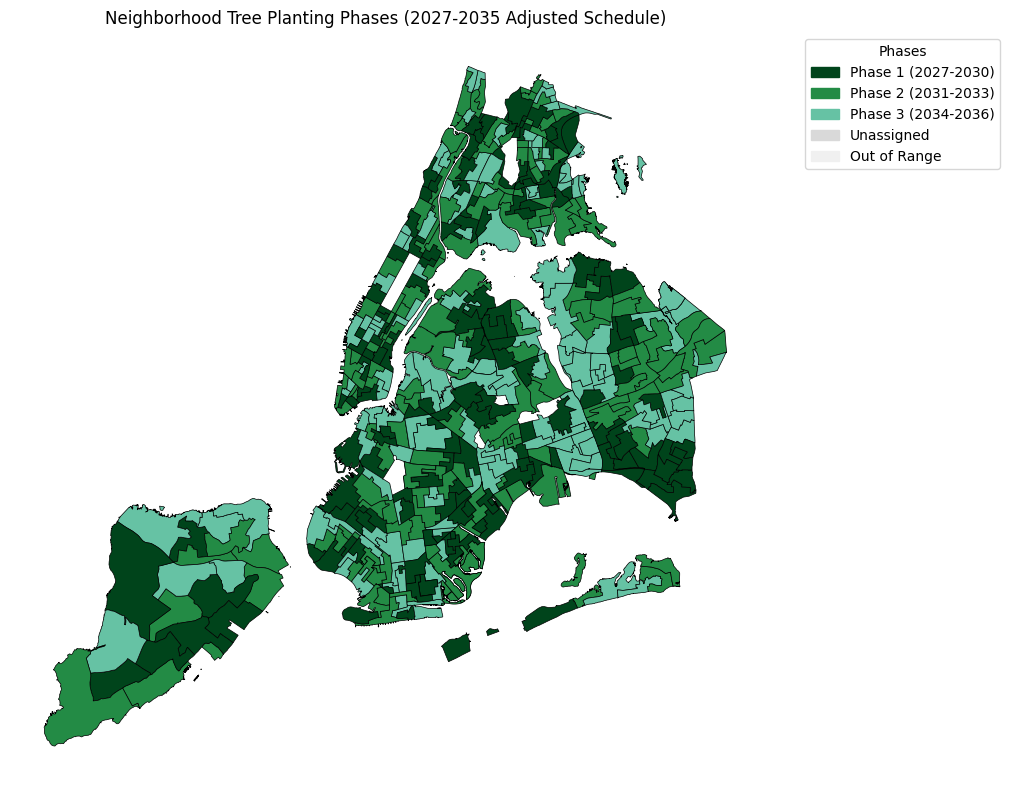

In [8]:
# Note: Assume merged_gdf has an 'Assigned_Year' column with years as integers

# Define a function to assign phases based on Assigned_Year
def assign_phase(year):
    if pd.isna(year):
        return "Unassigned"
    elif 1 <= year <= 3:
        return "Phase 1 (2027-2030)"
    elif 4 <= year <= 6:
        return "Phase 2 (2031-2033)"
    elif 7 <= year <= 9:
        return "Phase 3 (2034-2036)"
    else:
        return "Out of Range"

merged_gdf['Phase'] = merged_gdf['Assigned_Year'].apply(assign_phase)

# Define colors for the phases
phase_colors = {
    "Phase 1 (2027-2030)": "#00441b",  # dark green
    "Phase 2 (2031-2033)": "#238b45",  # medium green
    "Phase 3 (2034-2036)": "#66c2a4",  # light green
    "Unassigned": "#d9d9d9",           # light gray for unassigned zones
    "Out of Range": "#f0f0f0"          # very light gray for anything outside expected years
}

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf.plot(
    ax=ax,
    color=merged_gdf['Phase'].map(phase_colors),
    edgecolor='black',
    linewidth=0.5
)

# Legend patches
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=color, label=phase) for phase, color in phase_colors.items()]

plt.legend(handles=patches, title="Phases", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title("Neighborhood Tree Planting Phases (2027-2035 Adjusted Schedule)")
ax.axis('off')
plt.tight_layout()
plt.show()

# Distribution of Transition Zones in the 2027-2023 Cycle

Number of zones in the transition phase: 52
Sum of zones: 54


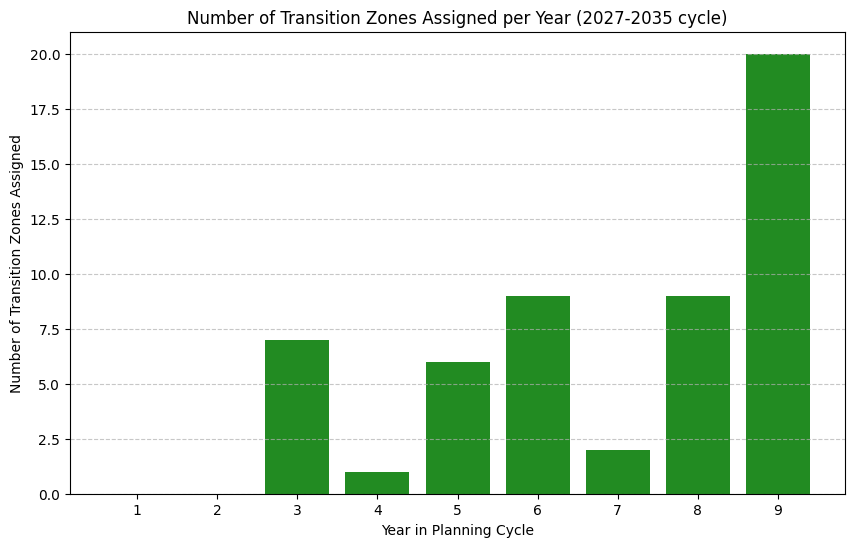

In [9]:
from collections import defaultdict

# find zones in the transition phase
transition_zones = []
for tid, row in mapping_transition_zones.iterrows():
    for merge_id in row["merge_id"]:
        if merge_id not in transition_zones:
          transition_zones.append(merge_id)

print("Number of zones in the transition phase: " + str(len(transition_zones)))

# Initialize counts per year
zone_counts_by_year = defaultdict(int)

for var in model.variables():
    if var.name.startswith("x_") and var.varValue == 1:
        parts = var.name.split('_')
        cb = parts[1]
        i = "_".join(parts[1:-1])
        row = zones.loc[i]
        dist = row["Council District"]
        num_trees = row["Planting Potential"]
        merge_id = str(cb) + "_" + str(dist) + "_" + str(num_trees)
        assigned_year = model_assignment[i] # 1-index

        if merge_id in transition_zones:
          zone_counts_by_year[assigned_year] += 1

Y_1 = [1,2,3,4,5,6,7,8,9]
print("Sum of zones: " + str(sum(zone_counts_by_year[i] for i in Y_1)))
# Prepare data for plotting
years = sorted(zone_counts_by_year.keys())
counts = [zone_counts_by_year[y] for y in years]

# Adjust years for display if zero-based
display_years = [y for y in years]  # e.g., show years as 1-9 instead of 0-8

plt.figure(figsize=(10,6))
plt.bar(display_years, counts, color='forestgreen')
plt.xlabel("Year in Planning Cycle")
plt.ylabel("Number of Transition Zones Assigned")
plt.title("Number of Transition Zones Assigned per Year (2027-2035 cycle)")
plt.xticks(display_years)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Distribution of Trees Planted Throughout the Cycle

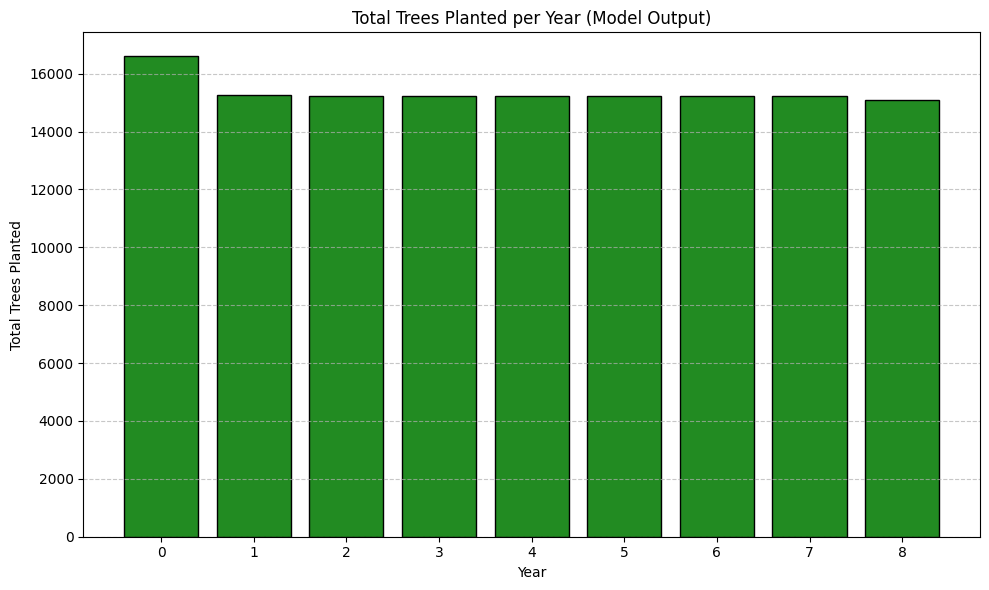

In [10]:
# Sum tree counts per year from model assignments
trees_per_year = {j: 0 for j in Y}

planting_potentials = {i: row["Planting Potential"] for i, row in zones.iterrows()}
for (i, j), var in x.items():
    if var.varValue == 1:
        trees_per_year[j] += planting_potentials[i]

# Convert to sorted lists for plotting
years = sorted(trees_per_year.keys())
tree_counts = [trees_per_year[y] for y in years]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(years, tree_counts, color='forestgreen', edgecolor='black')
plt.xlabel("Year")
plt.ylabel("Total Trees Planted")
plt.title("Total Trees Planted per Year (Model Output)")
plt.xticks(years)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Number of Zones Assigned Per Year by HVI Score (Equality)

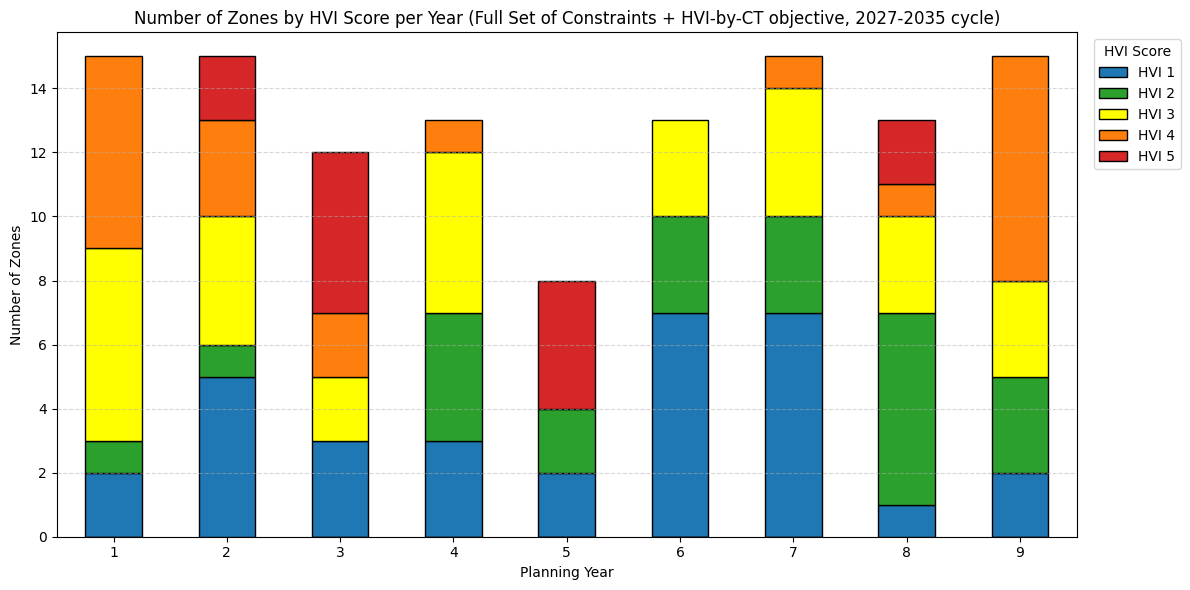

In [11]:
# Step 1: Extract assigned zones from model4
data = []

for var in model.variables():
    if var.name.startswith("x_") and var.varValue == 1:
      # Parse variable name: x_{i}_{j}
      parts = var.name.split("_")
      i = "_".join(parts[1:-1])  # handle zone names with underscores
      j = int(parts[-1])
      hvi = hvi_scores[i]
      data.append({"Zone": i, "Year": j + 1, "HVI": hvi})

df = pd.DataFrame(data)

# Step 2: Count zones by Year and HVI (ensuring all HVI levels present)
hvi_levels = [1, 2, 3, 4, 5]
zone_counts = (
    df.groupby(["Year", "HVI"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=hvi_levels, fill_value=0)
)

# Step 3: Define color map
color_map = {
    1: "#1f77b4",  # blue
    2: "#2ca02c",  # green
    3: "#FFFF00",  # yellow
    4: "#ff7f0e",  # orange
    5: "#d62728",  # red
}
colors = [color_map[hvi] for hvi in hvi_levels]

# Step 4: Plot stacked bar chart
ax = zone_counts.plot(
    kind="bar",
    stacked=True,
    color=colors,
    figsize=(12, 6),
    edgecolor="black"
)

plt.title("Number of Zones by HVI Score per Year (Full Set of Constraints + HVI-by-CT objective, 2027-2035 cycle)")
plt.xlabel("Planning Year")
plt.ylabel("Number of Zones")
plt.xticks(rotation=0)
plt.legend(
    title="HVI Score",
    labels=[f"HVI {hvi}" for hvi in hvi_levels],
    bbox_to_anchor=(1.01, 1),
    loc='upper left'
)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Number of Zones Visited Per Year by Borough (Equity)

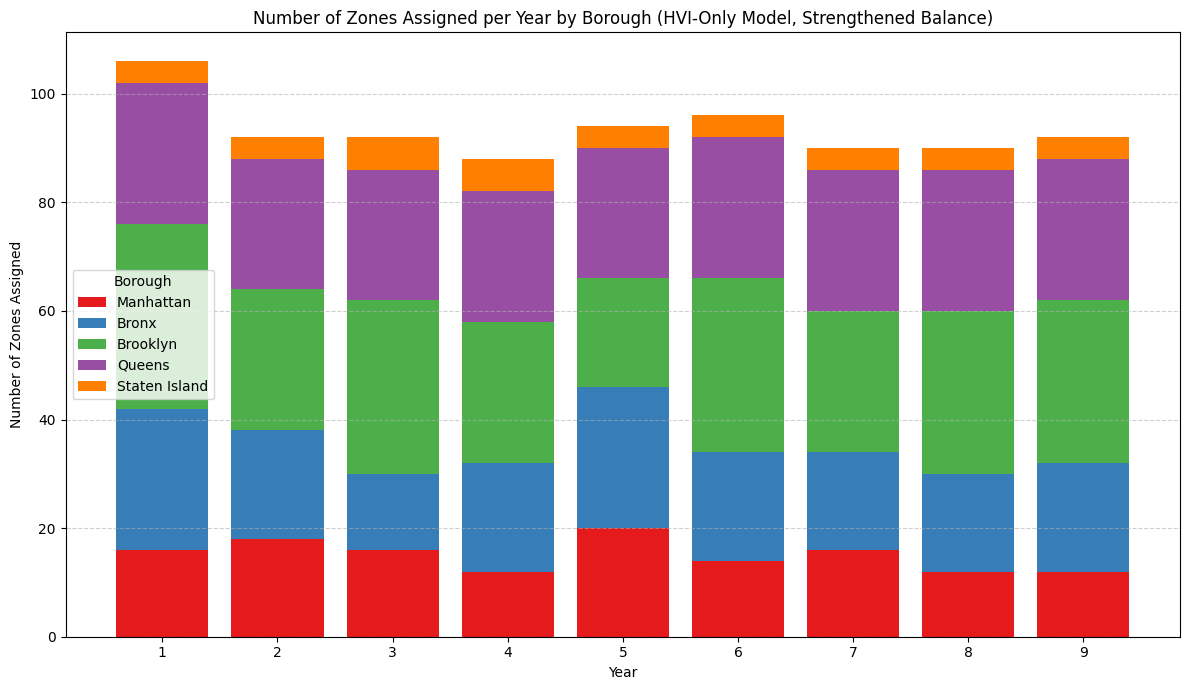

In [12]:
# Create a matrix to hold counts: rows = boroughs (5), cols = years (9)
borough_counts = np.zeros((5, 9))


for var in model.variables():
    if var.name.startswith("x_") and var.varValue == 1:
        parts = var.name.split('_')
        cb = int(parts[1])
        year = int(parts[3])  # 0-based
        borough = cb // 100  # Extract borough code (1–5)
        borough_counts[borough -1, year] += 1  # Adjust for 0-index
        borough_counts[borough -1, year] += 1  # Adjust for 0-index

# Plotting
years = np.arange(1, 10)  # 1–9
borough_labels = ["Manhattan", "Bronx", "Brooklyn", "Queens", "Staten Island"]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']  # Distinct colors

plt.figure(figsize=(12, 7))
bottom = np.zeros(9)

# Stack each borough
for i in range(5):
    plt.bar(years, borough_counts[i], bottom=bottom, label=borough_labels[i], color=colors[i])
    bottom += borough_counts[i]

plt.xlabel("Year")
plt.ylabel("Number of Zones Assigned")
plt.title("Number of Zones Assigned per Year by Borough (HVI-Only Model, Strengthened Balance)")
plt.xticks(years)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Borough")
plt.tight_layout()
plt.show()

# HVI Area Coverage between 2025-2029 In Model Solution

In [17]:
zones_resetindex["Zone_Unique"] = zones_resetindex["Unique"]
zones_resetindex = zones.reset_index()
zones_resetindex


# Set threshold and filter high-HVI CTs
hvi_threshold = 4
high_hvi_ct = ct_shp[ct_shp["QUINTILES"] >= hvi_threshold].copy()
total_high_hvi_area = high_hvi_ct.geometry.area.sum()
# print(f"Total High-HVI Area: {total_high_hvi_area}")

# Ensure CRS match
transition_shp = transition_shp.to_crs(ct_shp.crs)
zone_shp = zone_shp.to_crs(ct_shp.crs)

### --- Transition Coverage --- ###
# Spatial join to map CTs to transition zones
ct_with_transition = gpd.sjoin(high_hvi_ct, transition_shp, how='inner', predicate='intersects')

# Attach transition geometries
ct_with_transition = ct_with_transition.merge(
    transition_shp[['geometry']],
    left_on='index_right',
    right_index=True,
    how='left',
    suffixes=('', '_transition')
)

# Calculate intersection areas
ct_with_transition['Transition_Intersection'] = ct_with_transition.geometry.intersection(ct_with_transition['geometry_transition'])
ct_with_transition['Transition_Area'] = ct_with_transition['Transition_Intersection'].area

# Total area covered by transitions
transition_covered_area = ct_with_transition['Transition_Area'].sum()
# print(f"Transition Plan Covered Area: {transition_covered_area}")


### --- Phase 1 Coverage (Years 1-2) --- ###

# 1. Merge Zone-Year assignments with zone geometries
zone_years = zone_shp.merge(
    zones_resetindex[['merge_id', 'Unique', 'Assigned_Year']],
    on='merge_id',
    how='left'
).rename(columns={'geometry': 'Zone_Geometry'})

# 2. Merge zones into CT assignment table
zone_ct_with_years = zone_ct_pgi.merge(
    zone_years[['Unique', 'Zone_Geometry', 'Assigned_Year']],
    left_on='Zone_Unique',
    right_on = 'Unique',
    how='left'
)

# 3. Merge in CT geometries
ct_geometries = ct_shp[['BoroCT2010', 'geometry']].copy()

zone_ct_with_years = zone_ct_with_years.merge(
    ct_geometries,
    on='BoroCT2010',
    how='left'
)

# 4. Filter only high-HVI CTs
zone_ct_with_years = zone_ct_with_years[
    zone_ct_with_years['BoroCT2010'].isin(high_hvi_ct['BoroCT2010'].astype(str))
].copy()

# Ensure GeoDataFrame is set to CT geometries
zone_ct_with_years = gpd.GeoDataFrame(zone_ct_with_years, geometry='geometry', crs=ct_shp.crs)

# 5. Filter to Phase 1
phase1_ct = zone_ct_with_years[zone_ct_with_years['Assigned_Year'] <= 2].copy()

# 6. Calculate intersection (CT geometry vs. Zone geometry)
phase1_ct['Intersection'] = phase1_ct.geometry.intersection(phase1_ct['Zone_Geometry'])
phase1_ct['Intersection_Area'] = phase1_ct['Intersection'].area

# 7. Total Phase 1 covered area
phase1_area = phase1_ct['Intersection_Area'].sum()
# print(f"Phase 1 (Years 1-2) Covered Area: {phase1_area}")

### --- Percentages --- ###
percent_covered_by_transition = (transition_covered_area / total_high_hvi_area) * 100
percent_covered_by_phase1 = (phase1_area / total_high_hvi_area) * 100

print(f"Percentage of High-HVI Area Covered by Transition Plan: {percent_covered_by_transition:.2f}%")
print(f"Percentage of High-HVI Area Covered in Phase 1 (Years 1-2): {percent_covered_by_phase1:.2f}%")

### --- Overlap --- ###
# Create a common CT ID
phase1_ct['CT_ID'] = phase1_ct['BoroCT2010'].astype(str)
ct_with_transition['CT_ID'] = ct_with_transition['BoroCT2010'].astype(str)

# Important: Drop geometry column from one of the datasets to prevent merge errors
ct_with_transition_clean = ct_with_transition.drop(columns='geometry')

# Merge to get overlapping CTs
overlap_df = ct_with_transition_clean.merge(phase1_ct, on='CT_ID', suffixes=('_transition', '_phase1'))

# Calculate intersection of transition and phase 1 coverage
overlap_df['Overlap_Area'] = overlap_df['Transition_Intersection'].intersection(overlap_df['Intersection']).area

# Sum total overlap area
overlap_area = overlap_df['Overlap_Area'].sum()
# print(f"Overlap Area: {overlap_area}")

### --- Unique Areas --- ###
unique_transition_area = transition_covered_area - overlap_area
unique_phase1_area = phase1_area - overlap_area

# print(f"Unique Transition Plan Coverage: {(unique_transition_area / total_high_hvi_area) * 100:.2f}%")
# print(f"Unique Phase 1 Coverage: {(unique_phase1_area / total_high_hvi_area) * 100:.2f}%")
print(f"Overlap Coverage: {(overlap_area / total_high_hvi_area) * 100:.2f}%")

total_coverage = (transition_covered_area + phase1_area - overlap_area) / total_high_hvi_area * 100
print(f"Total high-HVI area % coverage: {total_coverage:.2f}%")

adjusted_high_hvi = zones[zones["HVI"] >= 4]
print("Adjusted avg year (high-HVI):", adjusted_high_hvi["Assigned_Year"].mean())

Percentage of High-HVI Area Covered by Transition Plan: 37.99%
Percentage of High-HVI Area Covered in Phase 1 (Years 1-2): 23.75%
Overlap Coverage: 2.32%
Total high-HVI area % coverage: 59.43%
Adjusted avg year (high-HVI): 4.963414634146342


# HVI Area Coverage between 2025-2029 In Tyler's Solution

In [1]:
import geopandas as gpd

# Set threshold and filter high-HVI CTs
hvi_threshold = 4
high_hvi_ct = ct_shp[ct_shp["QUINTILES"] >= hvi_threshold].copy()
total_high_hvi_area = high_hvi_ct.geometry.area.sum()
print(f"Total High-HVI Area: {total_high_hvi_area}")

# Ensure CRS match
transition_shp = transition_shp.to_crs(ct_shp.crs)
zone_shp = zone_shp.to_crs(ct_shp.crs)

### --- Transition Coverage --- ###
# Spatial join to map CTs to transition zones
ct_with_transition = gpd.sjoin(high_hvi_ct, transition_shp, how='inner', predicate='intersects')

# Attach transition geometries
ct_with_transition = ct_with_transition.merge(
    transition_shp[['geometry']],
    left_on='index_right',
    right_index=True,
    how='left',
    suffixes=('', '_transition')
)

# Calculate intersection areas
ct_with_transition['Transition_Intersection'] = ct_with_transition.geometry.intersection(ct_with_transition['geometry_transition'])
ct_with_transition['Transition_Area'] = ct_with_transition['Transition_Intersection'].area

# Total area covered by transitions
transition_covered_area = ct_with_transition['Transition_Area'].sum()
print(f"Transition Plan Covered Area: {transition_covered_area}")

### --- Phase 1 Coverage (Years 1-2) --- ###

# 1. Merge Zone-Year assignments with zone geometries
zone_years = zone_shp.merge(
    zones_resetindex[['merge_id', 'Zone_Unique', 'New Year Assignment']],
    on='merge_id',
    how='left'
).rename(columns={'geometry': 'Zone_Geometry'})

# 2. Merge zones into CT assignment table
zone_ct_with_years = zone_ct_pgi.merge(
    zone_years[['Zone_Unique', 'Zone_Geometry', 'New Year Assignment']],
    on='Zone_Unique',
    how='left'
)

# 3. Merge in CT geometries
ct_geometries = ct_shp[['BoroCT2010', 'geometry']].copy()

zone_ct_with_years = zone_ct_with_years.merge(
    ct_geometries,
    on='BoroCT2010',
    how='left'
)

# 4. Filter only high-HVI CTs
zone_ct_with_years = zone_ct_with_years[
    zone_ct_with_years['BoroCT2010'].isin(high_hvi_ct['BoroCT2010'].astype(str))
].copy()

# Ensure GeoDataFrame is set to CT geometries
zone_ct_with_years = gpd.GeoDataFrame(zone_ct_with_years, geometry='geometry', crs=ct_shp.crs)

# 5. Filter to Phase 1
phase1_ct = zone_ct_with_years[zone_ct_with_years['New Year Assignment'] <= 2].copy()

# 6. Calculate intersection (CT geometry vs. Zone geometry)
phase1_ct['Intersection'] = phase1_ct.geometry.intersection(phase1_ct['Zone_Geometry'])
phase1_ct['Intersection_Area'] = phase1_ct['Intersection'].area

# 7. Total Phase 1 covered area
phase1_area = phase1_ct['Intersection_Area'].sum()
print(f"Phase 1 (Years 1-2) Covered Area: {phase1_area}")

### --- Percentages --- ###
percent_covered_by_transition = (transition_covered_area / total_high_hvi_area) * 100
percent_covered_by_phase1 = (phase1_area / total_high_hvi_area) * 100

print(f"Percentage of High-HVI Area Covered by Transition Plan: {percent_covered_by_transition:.2f}%")
print(f"Percentage of High-HVI Area Covered in Phase 1 (Years 1-2): {percent_covered_by_phase1:.2f}%")

### --- Overlap --- ###
# Create a common CT ID
phase1_ct['CT_ID'] = phase1_ct['BoroCT2010'].astype(str)
ct_with_transition['CT_ID'] = ct_with_transition['BoroCT2010'].astype(str)

# Important: Drop geometry column from one of the datasets to prevent merge errors
ct_with_transition_clean = ct_with_transition.drop(columns='geometry')

# Merge to get overlapping CTs
overlap_df = ct_with_transition_clean.merge(phase1_ct, on='CT_ID', suffixes=('_transition', '_phase1'))

# Calculate intersection of transition and phase 1 coverage
overlap_df['Overlap_Area'] = overlap_df['Transition_Intersection'].intersection(overlap_df['Intersection']).area

# Sum total overlap area
overlap_area = overlap_df['Overlap_Area'].sum()
print(f"Overlap Area: {overlap_area}")

### --- Unique Areas --- ###
unique_transition_area = transition_covered_area - overlap_area
unique_phase1_area = phase1_area - overlap_area

print(f"Unique Transition Plan Coverage: {(unique_transition_area / total_high_hvi_area) * 100:.2f}%")
print(f"Unique Phase 1 Coverage: {(unique_phase1_area / total_high_hvi_area) * 100:.2f}%")
print(f"Overlap Coverage: {(overlap_area / total_high_hvi_area) * 100:.2f}%")

total_coverage = (transition_covered_area + phase1_area - overlap_area) / total_high_hvi_area * 100
print(f"Total high-HVI area % coverage: {total_coverage:.2f}%")

NameError: name 'ct_shp' is not defined